## Read before proceed

0. Most of the codes here are copied from [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). I don`t think these codes comply with the currently accepted standards. **So treat them carefully**
1. This `.ipynb` file should be placed outside of `kaggleData` file
2. Change `file_path` if running in a local machine with gpu
3. The `n_words` (vocab size) of `Lang` class affects the dimensions of Encoder, but our hw requires a random split of 90% for training, hence such split changes `n_words` every time you run this file for training. So i set `random_state = 1234` at `sklearn.train_test_split` to make training reproducible. 
4. Do not change `random_state` if you are using the existed weights `encoder_weights.pth` `decoder_weights.pth`. If you change `random_state`, you will have to re-train yourself.

In [1]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# ======= features from python 2.x, no need here ========
import unicodedata
import re
import random
import torch
import os
import pickle
import numpy as np

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore") 


# ========================= PATH ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cpu':
    file_path = './kaggleData/data/'
else:
    file_path = '/kaggle/input/eng-cmn/'

# create a folder to store ouputs
folder_path = './misc'
try:
    os.mkdir(folder_path)
except Exception as e:
    print(f'{e}')


[WinError 183] 当文件已存在时，无法创建该文件。: './misc'


In [2]:
# encoding words

SOS_token = 0
EOS_token = 1
UNK_token = 2

# old Land: count based
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<UNK>": UNK_token}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "<UNK>"}
        self.n_words = 3  # Count SOS and EOS + UNK

    def addSentence(self, sentence):

        for word in sentence.split(' '):
            self.addWord(word)


    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1

        else:
            self.word2count[word] += 1


# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# deal with english letters: lower case + strip all punctuation
def normalize_english(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

# deal with chinese words: strip all punctuation
def normalize_chinese(s):
    s = s.strip()
    s = ' '.join(list(s)) 
    s = re.sub(r'\s+', ' ', s)
    return s.strip()


In [3]:
# read data (cn2eng)
def read_langs(lang1, lang2, file_path = file_path, test_size = 0.1, reverse=False):
    # lines = open('data/cmn.txt', encoding='utf-8').read().split('\n')
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(file_path + '%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    # print(file_path + '%s-%s.txt' % (lang1, lang2))
    pairs = []
    for line in lines:
        parts = line.split('\t')
        if len(parts) < 2: continue
        en = normalize_english(parts[0].strip())
        zh = normalize_chinese(parts[1].strip())
        pairs.append([zh, en] if reverse else [en, zh])
    input_lang = Lang(lang2) if reverse else Lang(lang1)
    output_lang = Lang(lang1) if reverse else Lang(lang2)



    # ================== split data to train/test set ==================
    
    # random_state for reproduction, otherwise saved weights cannot be loaded properly
    pairs, pairs_test = train_test_split(pairs, test_size=test_size, shuffle=True, random_state = 1234)
    return input_lang, output_lang, pairs, pairs_test
    # return input_lang, output_lang, pairs


In [4]:
# filter data, extract short sentence

MAX_LENGTH = 45 # 45: the minimal length that can use the whole data set without being trimmed/filtered

# filter out text-pairs that exceed MAX_LENGTH: for test
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, file_path ,test_size = 0.1, reverse=False):
    # input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    input_lang, output_lang, pairs, pairs_test = read_langs(lang1, lang2,file_path, test_size , reverse)
    # input_lang, output_lang, pairs = read_langs(lang1, lang2,file_path, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    pairs_test = filterPairs(pairs_test)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs, pairs_test


# ============ test if data are loaded and prepared as expected: =============
input_lang, output_lang, pairs, pairs_test = prepareData('eng', 'cmn',file_path = file_path, test_size = 0.1, reverse=True)
print(random.choice(pairs))
print(input_lang.n_words)



Reading lines...
Read 26918 sentence pairs
Trimmed to 26918 sentence pairs
Counting words...
Counted words:
cmn 3594
eng 6724
['我 可 以 問 你 一 些 問 題 嗎 ？', 'may i ask you some more questions ?']
3594


In [5]:
# define encode-decoder rnn

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden    

# introduce decoder with attn
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [6]:
# prepare data from training
def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size, test_size):
    # input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
    # pairs: 90% data for train
    # pairs_test: 10% data for test
    input_lang, output_lang, pairs, pairs_test = prepareData('eng', 'cmn', file_path=file_path, test_size = test_size, reverse=True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    # ============== build data loader =======================
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    # ===============================================
    
    return input_lang, output_lang, train_dataloader, pairs_test

In [7]:
# training misc: define training loop / plot loss curve / print time consumed etc

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def plotLoss(training_loss, max_epochs):
    epochs = list(range(5, max_epochs+1, 5))  # [5,10,...,80]

    plt.figure(figsize=(8, 6))

    line = plt.plot(epochs, training_loss, 
                    marker='o',          
                    markersize=8,        
                    markerfacecolor='red', 
                    markeredgecolor='black', 
                    linewidth=2, 
                    linestyle='--', 
                    color='steelblue')
    plt.xticks(epochs, fontsize=10, rotation=45) 
    plt.yticks(np.arange(0, 1, 0.05), fontsize=10) 
    plt.xlabel('Training Epochs (5-80, step=5)', 
            fontsize=12, labelpad=10, weight='bold')
    plt.ylabel('Loss Value', 
            fontsize=12, labelpad=10, weight='bold')
    plt.title('Training Loss (5-epoch Intervals)', 
            fontsize=14, pad=20, weight='bold')

    plt.grid(True, linestyle='--', alpha=0.7, which='both')


    last_point = (epochs[-1], training_loss[-1])
    plt.annotate(f'Final Loss: {training_loss[-1]:.2f}',
                xy=last_point,
                xytext=(last_point[0]-10, last_point[1]+0.2),
                arrowprops=dict(arrowstyle='->', color='gray'),
                fontsize=10)


    plt.xlim(0, 85)
    plt.ylim(min(training_loss)-0.1, max(training_loss)+0.1)
    plt.tight_layout()
    plt.savefig('misc/seq2seq_loss.png')
    plt.show()

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=10, plot_every=10):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    # print(f'plot_every: {plot_every}')

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

In [8]:
# eval 

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        # input_tensor = sentence
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])

    return decoded_words, decoder_attn

# pick n = 20 entries from test set to evaluate
def evaluateRandomly(text_pairs, encoder, decoder,  n=20):
    sentence = []
    for i in range(n):
        pair = random.choice(text_pairs)
        sentence.append(pair[0])
        print('input: ', pair[0])
        print('target: ', pair[1])
        # print(pair[0])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('model: ', output_sentence)
        print('')
    return sentence
    

In [10]:
# hyper params
hidden_size = 128 # a.k.a 'd_model': max num of dimension of input tensor the model can deal with
batch_size = 32
max_epochs = 80
test_size = 0.1 # 10% of the data will be used as test set
print_every = 5 # print training info (loss) every 5 epoch
plot_every = 5 # record loss value every 5 epoch

input_lang, output_lang, train_dataloader, pairs_test = get_dataloader(batch_size, test_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# # start training
if device.type == 'cuda':
    seq2seq_loss = train(train_dataloader, encoder, decoder, max_epochs, print_every=5, plot_every=5)

    # save model
    torch.save(encoder.state_dict(), "misc/encoder_weights.pth")
    torch.save(decoder.state_dict(), "misc/decoder_weights.pth")
    
    # save training loss
    with open('misc/seq2seq_loss.pkl', 'wb') as file:
        pickle.dump(seq2seq_loss, file)
else:
    print('training disabled, use downloaded weights')

Reading lines...
Read 26918 sentence pairs
Trimmed to 26918 sentence pairs
Counting words...
Counted words:
cmn 3594
eng 6724
training disabled, use downloaded weights


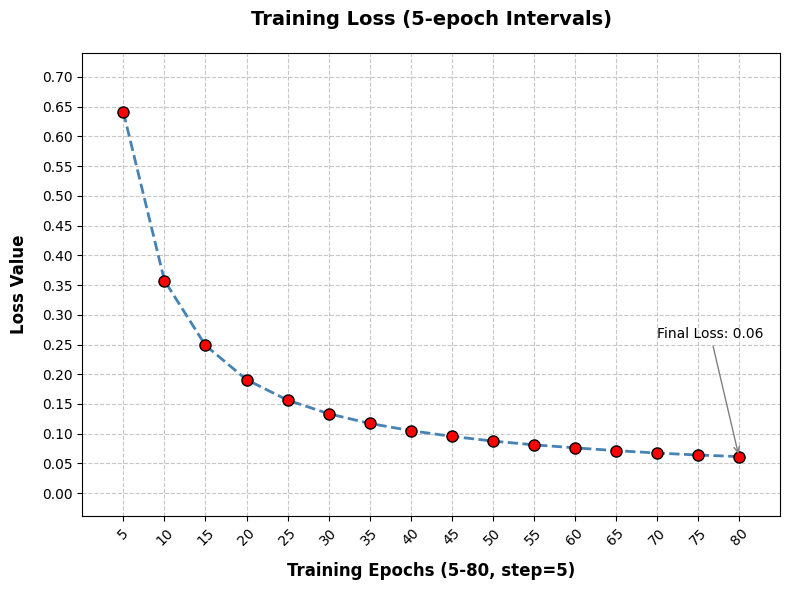

In [13]:
# plot training loss
with open('misc/seq2seq_loss.pkl', 'rb') as file:
    seq2seq_loss = pickle.load(file)

plotLoss(seq2seq_loss, max_epochs)

In [14]:
# reload model from saved file
encoder.load_state_dict(torch.load('misc/encoder_weights.pth', map_location=device))
decoder.load_state_dict(torch.load('misc/decoder_weights.pth', map_location=device))
encoder.eval()
decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(6724, 128)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=128, out_features=128, bias=True)
    (Ua): Linear(in_features=128, out_features=128, bias=True)
    (Va): Linear(in_features=128, out_features=1, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=6724, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [18]:
# randomly evalue (translate) n=100 chinese text from test set
sentence = evaluateRandomly(pairs_test, encoder, decoder, n=10) # < ------------ test set

input:  您 想 再 来 点 茶 吗 ？
target:  would you like some more tea ?
model:  would you like tea ? <EOS>

input:  她 的 故 事 是 真 的 吗 ？
target:  was her story true ?
model:  is her story true story <EOS>

input:  比 我 想 象 中 的 更 简 单 。
target:  that was easier than i thought it would be
model:  i want less than i remember <EOS>

input:  湯 姆 問 了 幾 個 問 題 。
target:  tom asked a few questions
model:  tom bought questions <EOS>

input:  我 家 附 近 有 一 個 公 園 。
target:  there is a park near my house
model:  near my house <EOS>

input:  我 想 要 一 些 新 鲜 的 鸡 蛋 。
target:  i want some fresh eggs
model:  i want new <EOS>

input:  你 是 从 哪 个 国 家 来 的 ？
target:  what country are you from ?
model:  when are your country ? <EOS>

input:  这 个 城 市 人 口 众 多 。
target:  the city has a large population
model:  two men <EOS>

input:  永 远 别 再 提 它 了 。
target:  don t ever mention that again
model:  never want it again <EOS>

input:  汤 姆 开 始 唱 歌 。
target:  tom started singing
model:  tom started to sing <EOS>



In [19]:
# visualize attention
plt.rcParams['font.sans-serif'] = ['SimHei']  # use system chinese font
plt.rcParams['axes.unicode_minus'] = False    
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='plasma')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

input = 您 想 再 来 点 茶 吗 ？
output = would you like tea ? <EOS>


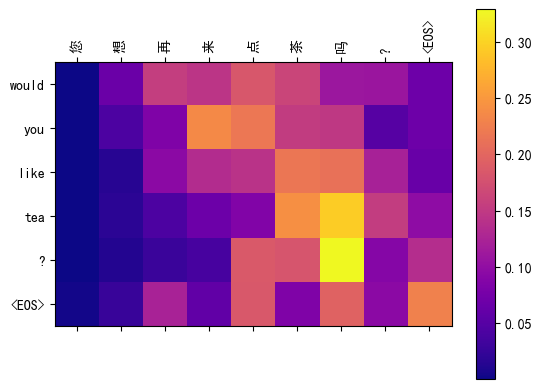

input = 她 的 故 事 是 真 的 吗 ？
output = is her story true story <EOS>


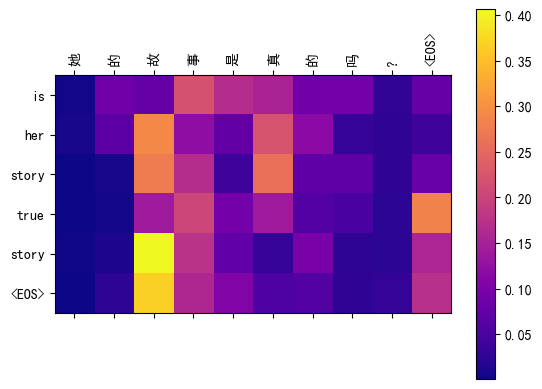

input = 比 我 想 象 中 的 更 简 单 。
output = i want less than i remember <EOS>


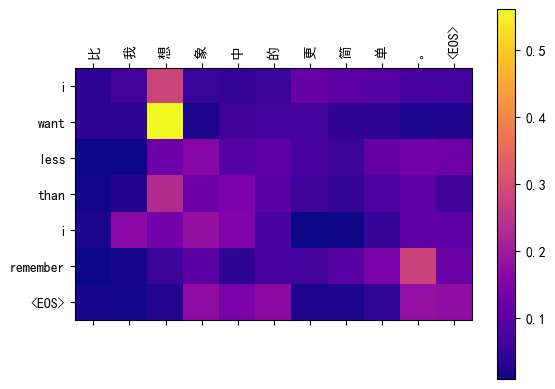

input = 湯 姆 問 了 幾 個 問 題 。
output = tom bought questions <EOS>


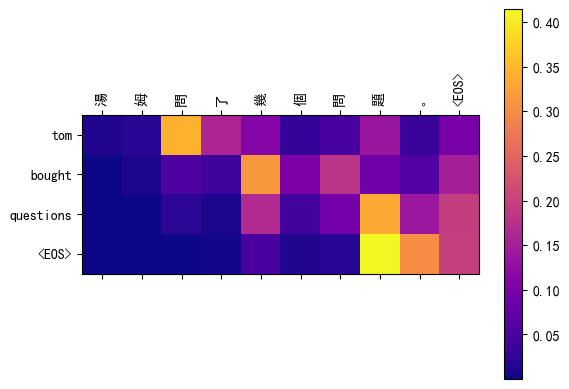

input = 我 家 附 近 有 一 個 公 園 。
output = near my house <EOS>


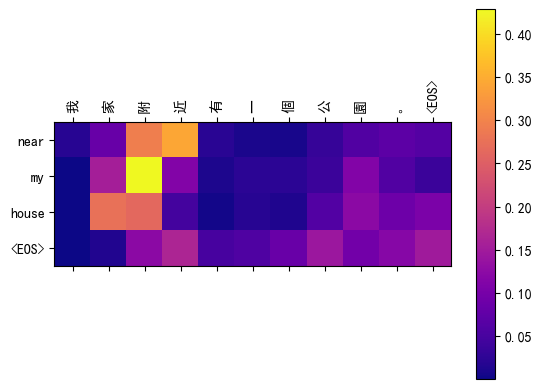

input = 我 想 要 一 些 新 鲜 的 鸡 蛋 。
output = i want new <EOS>


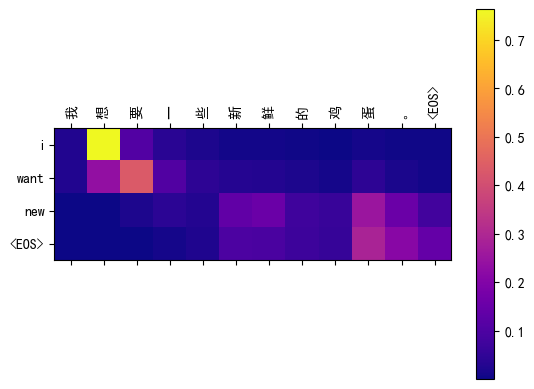

input = 你 是 从 哪 个 国 家 来 的 ？
output = when are your country ? <EOS>


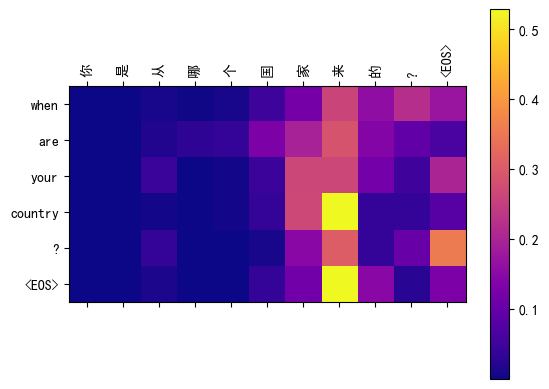

input = 这 个 城 市 人 口 众 多 。
output = two men <EOS>


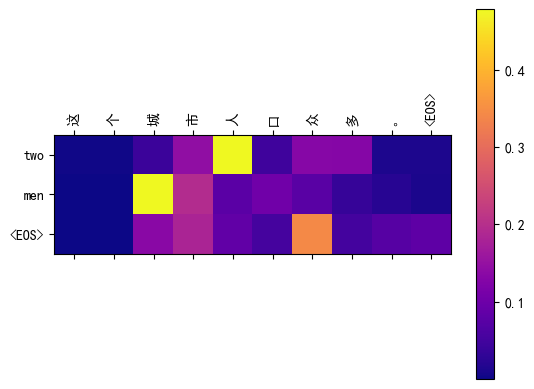

input = 永 远 别 再 提 它 了 。
output = never want it again <EOS>


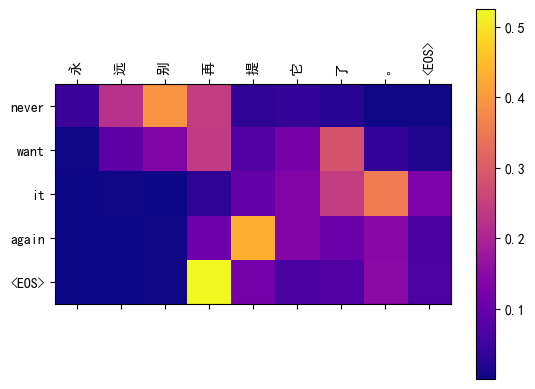

input = 汤 姆 开 始 唱 歌 。
output = tom started to sing <EOS>


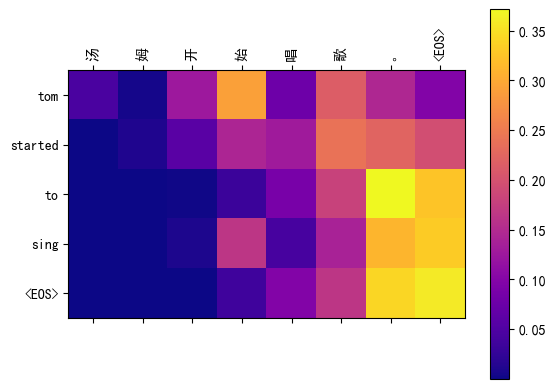

In [20]:
for sentence_ in sentence[:10]:
    evaluateAndShowAttention(sentence_)